In [1]:
%matplotlib inline
import matplotlib.pyplot as plt, mpld3
import pandas as pd, seaborn as sn, numpy as np
sn.set_context('talk')

In [2]:
# Hack to force Python 2 to recognise utf-8 encodings. See here:
# http://jonathansoma.com/tutorials/international-data/python-and-utf-8/
# Note that using this breaks subsequent print statements in the 
# notebook, which is annoying!
#import sys
#reload(sys)
#sys.setdefaultencoding("utf-8")

# Krypsiv project

Therese has a project on Bulbous Rushes (Krypsiv) and the first draft of the 2016 annual report is due in mid-November. This notebook explores some options for plotting different data types. **Finalised plots will be required no later than November 12th**.

For reference, the 2015 report is here:

K:\Avdeling\318 Ferskvannsøkologi\Prosjekter\2016 JBovervåk16-18 (TFM)\05 Rapport

and the raw data files are here:

K:\Avdeling\318 Ferskvannsøkologi\Prosjekter\2016 JBovervåk16-18 (TFM)\07 Grunndata

The file `Grunndata JBovervåk1618.xlsx` includes most of the data for all three years (2014 to 2016 inclusive). For further background, see the e-mail from Therese received 24/10/2016 at 20:23.

## 1. Compositional proportions

Page 21 of the 2015 report shows the proportion of the substrate covered by different classes of benthic algae; page 27 shows the proportions of different substrate types. Therese would like a visual presentation of these data for all three years.

As a start, I've extracted the proportions data from the raw spreadsheets into a new Excel file called `proportions.xlsx`. Note that for substrate there are several cases where the proportions sum to more than 100%, because the classes are not mutually exclusive. This is a little counter-intuitive and may pose problems for the data visualisation, so I might need to revisit this with Therese to see if we can aggregate the classes a bit.

Note also that I'm having some problems with special Norwegian characters in the site names causing `Unicode Errors` in my code. These issues should be fixed by uncommenting the cell above, but for testing and development I've decided to create a new `Name` column with the non-ASCII characters removed, as it's becoming difficult to know which errors are caused by my code and which are due to Unicode conversions.

During the initial meeting with Therese and Kate, I suggested representing the different proportions using [radar charts or spider diagrams](https://en.wikipedia.org/wiki/Radar_chart) but, having looked at the data, I think this approach will be messy and probably difficult to interpret. A better option may be to use some kind of **facet grid of bar charts**. I'll try a few different versions below.

### 1.1. Read data

First, read the proportions data.

In [3]:
# Read data
in_xls = (r'C:\Data\James_Work\Staff\Therese_FM\Bulbous_Rushes\Data'
          r'\Tidied\proportions.xlsx')
df = pd.read_excel(in_xls, sheetname='proportions')

# Define cols for algae and substrate
alg_cols = set(['BEGlost', 'BEGfast', 'BEGdelvis', 'BEGfri', 'BEGsum'])
sub_cols = set(['Boulders', 'Cobbles', 'Gravel', 'Fine gravel', 'Sand', 'Clay_silt', 'Organic', 'SUBsum'])

df.head()

,Kortnavn,Name,ID,River,Year,BEGlost,BEGfast,BEGdelvis,BEGfri,BEGsum,Boulders,Cobbles,Gravel,Fine gravel,Sand,Clay_silt,Organic,SUBsum
0,LOG,LOG,1,Mandalselva,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LOG,LOG,1,Mandalselva,2015,5.0,0.0,0.0,95.0,100.0,40.0,40.0,10.0,5.0,5.0,0.0,0.0,100.0
2,LOG,LOG,1,Mandalselva,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ÅSE,ASE,2,Mandalselva,2014,0.0,0.0,100.0,0.0,100.0,20.0,20.0,40.0,15.0,5.0,0.0,0.0,100.0
4,ÅSE,ASE,2,Mandalselva,2015,90.0,0.0,0.0,10.0,100.0,10.0,30.0,30.0,25.0,5.0,0.0,0.0,100.0


### 1.2. Extract algal coverage dataset

Then get just the algal data to work with. The substrate data can be processed pretty quickly in exactly the same way, once I've discussed the numbers with Therese and we've decided how we want to format the plots.

In [4]:
# Get just the algal data
alg_df = df[list(set(df.columns) - sub_cols)]
del alg_df['BEGsum']

# 'Melt' to long data format
alg_df = pd.melt(alg_df, 
                 id_vars=['Kortnavn', 'Name', 'ID', 'River', 'Year'], 
                 var_name='Class', 
                 value_name='Proportion (%)')

alg_df.head()

,Kortnavn,Name,ID,River,Year,Class,Proportion (%)
0,LOG,LOG,1,Mandalselva,2014,BEGfast,NaN
1,LOG,LOG,1,Mandalselva,2015,BEGfast,0.0
2,LOG,LOG,1,Mandalselva,2016,BEGfast,NaN
3,ÅSE,ASE,2,Mandalselva,2014,BEGfast,0.0
4,ÅSE,ASE,2,Mandalselva,2015,BEGfast,0.0


#### 1.2.1. Separate bar charts

The simplest and perhaps clearest way to visualise these data is to plot a separate bar chart for each site in each year, arranged with years as columns and sites as rows. This generates a 3 by 6 grid for each of the three rivers (i.e. 54 bar charts in total). This works OK, but the output takes up a lot of space - probably one page per river. Perhaps this is too much?

The example below shows the results for Mandalselva.

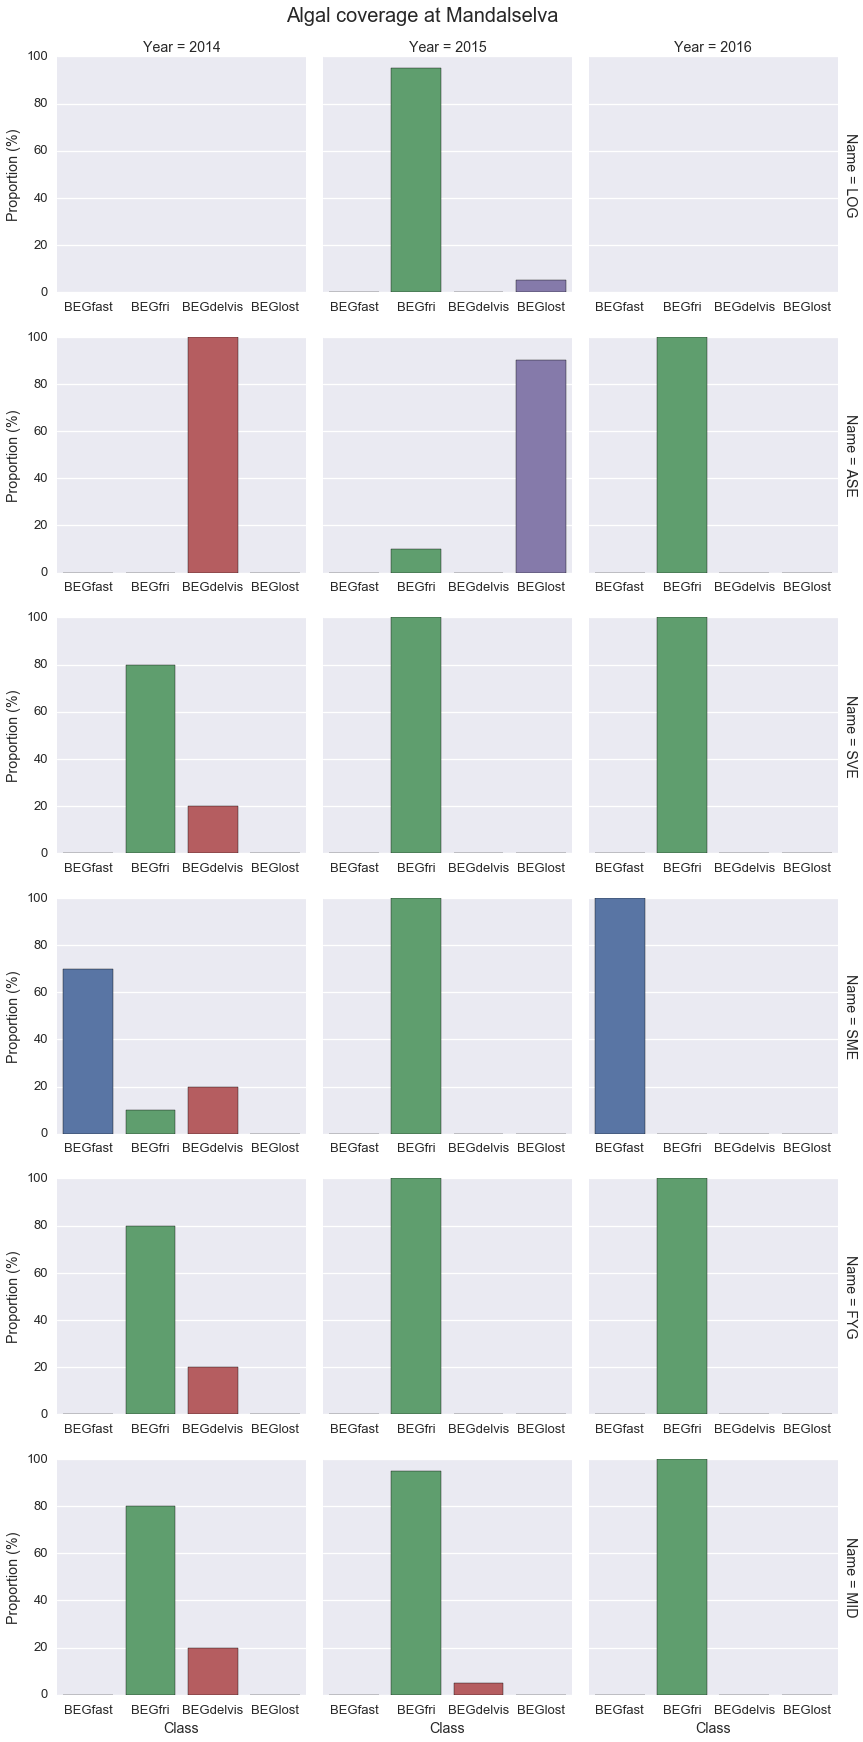

In [5]:
# Get data for Mandalselva
df2 = alg_df.query('River == "Mandalselva"')

# Plot
sn.factorplot(x='Class', y='Proportion (%)', 
              row='Name', col='Year',
              data=df2, 
              kind='bar',
              sharex=False, 
              margin_titles=True)

plt.suptitle('Algal coverage at Mandalselva', fontsize=20, y=1.01)

#### 1.2.2. Aggregate years

One way to compress the plot above is to use bars only for the value of the **median** year. Proportions for the other two years can then be represented by whiskers to show the range of variability within each class. This reduces the three columns on the plot above to a single column 6 plots high, which I've rearranged into a grid of 3 by 2 to save space.

This method of presenting the data is more compact, but we lose the time-ordering compared to the version above i.e. it is possible to read off the values for each year, but we don't which is year is which.

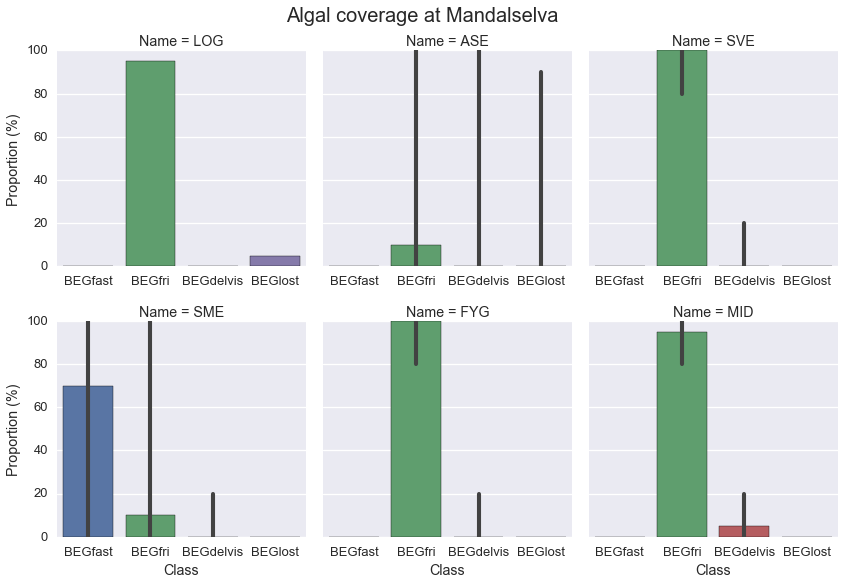

In [6]:
# Aggregate years for Mandalselva
sn.factorplot(x='Class', y='Proportion (%)', 
              col='Name', col_wrap=3,
              data=df2, 
              kind='bar',
              sharex=False, 
              estimator=np.median)

plt.suptitle('Algal coverage at Mandalselva', fontsize=20, y=1.02)

Using this method, it is possible to represent the whole dataset on a 3 by 6 grid, where each column represents a river, and each row a site on that river. In this way, all the data can be represented on a single page (but we still lose the time ordering).

**Note:** We actually need a 3 by 7 grid, as there are 7 sites on the Otra.

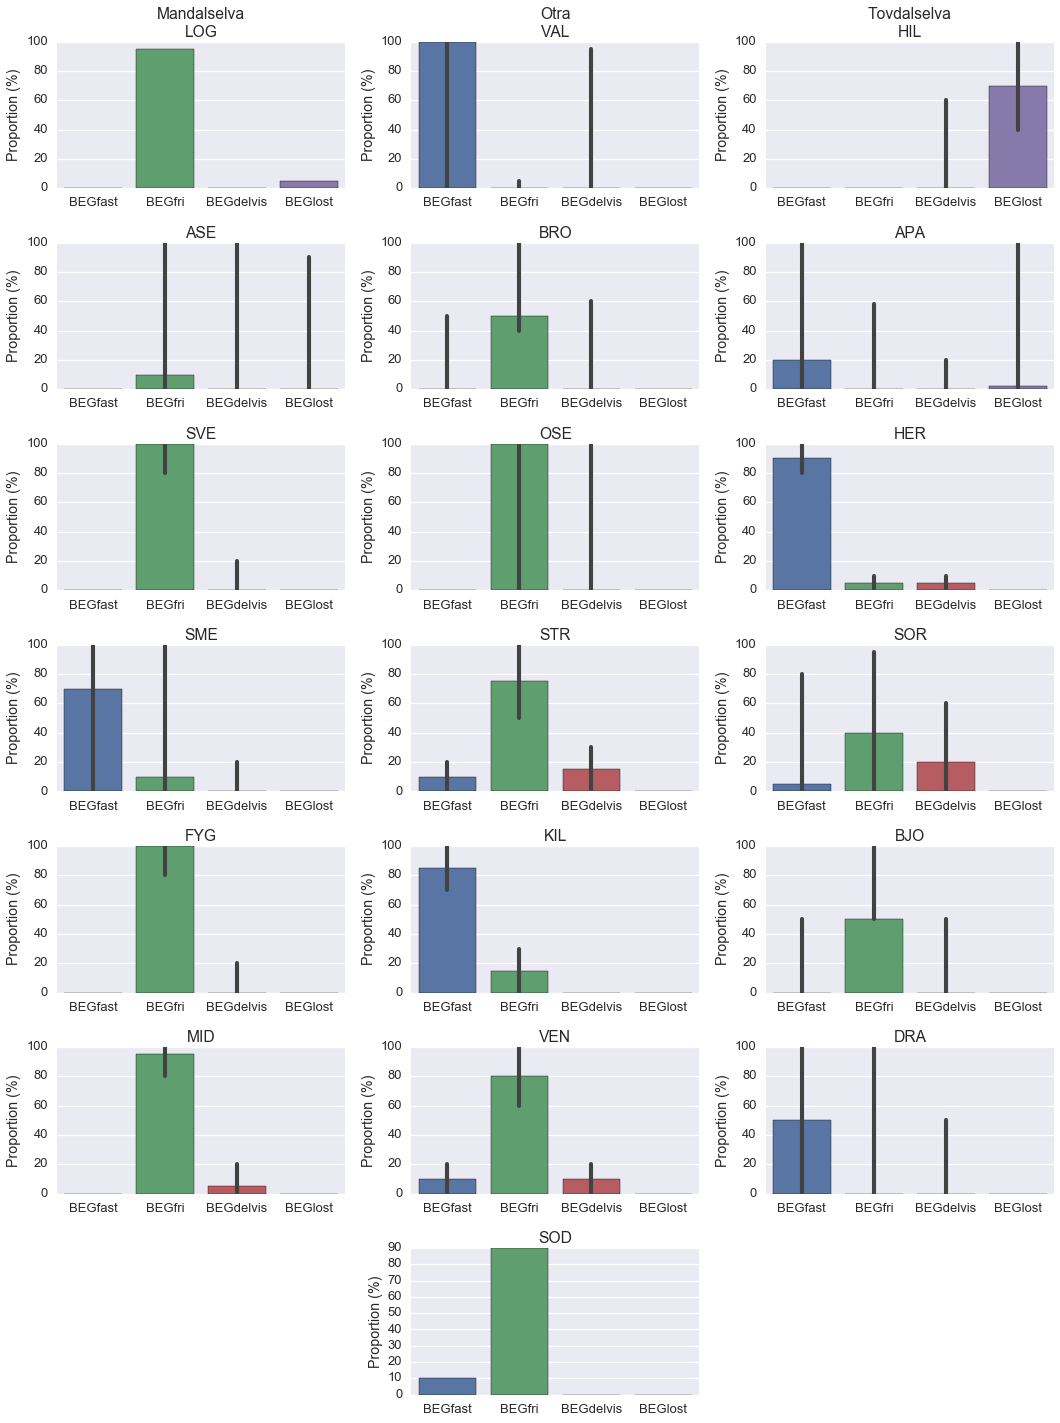

In [7]:
# Aggregated years for all sites
fig, axes = plt.subplots(nrows=7, ncols=3, 
                         figsize=(15,20))

# Rivers by column
for col, riv in enumerate(['Mandalselva', 'Otra', 'Tovdalselva']):
    riv_df = alg_df.query('River == @riv')

    # Sites by row
    for row, site in enumerate(riv_df['Name'].unique()):
        site_df = riv_df.query('Name == @site')
        sn.barplot(x='Class', y='Proportion (%)', 
                   data=site_df, 
                   ax=axes[row, col],
                   estimator=np.median) 
        
        # Add labels
        axes[row, col].set_ylabel('Proportion (%)')
        axes[row, col].set_xlabel('')
        if row == 0:
            axes[row, col].set_title('%s\n%s' % (riv, site))
        else:
            axes[row, col].set_title(site)

# We only have 6 sites at Mandalselva and Tovdalselva, so
# remove 7th row for these
fig.delaxes(axes[6, 0])
fig.delaxes(axes[6, 2])

plt.tight_layout()

#### 1.2.3. Aggregate categories

A different way to aggregate these data is to group the classes into stacked bar charts, which means we can separate out the years again. As above, this allows the whole dataset to be represented on a 3 by 6 (7 for Otra) grid, and with this method the time ordering is preserved too, but it's more difficult to read off the actual proportions for each class. It does give a reasonable visual impression of the relative class proportions, though, which is perhpas all that's required?

C:\Data\64_Bit_WinPython\python-2.7.10.amd64\lib\site-packages\ipykernel\__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


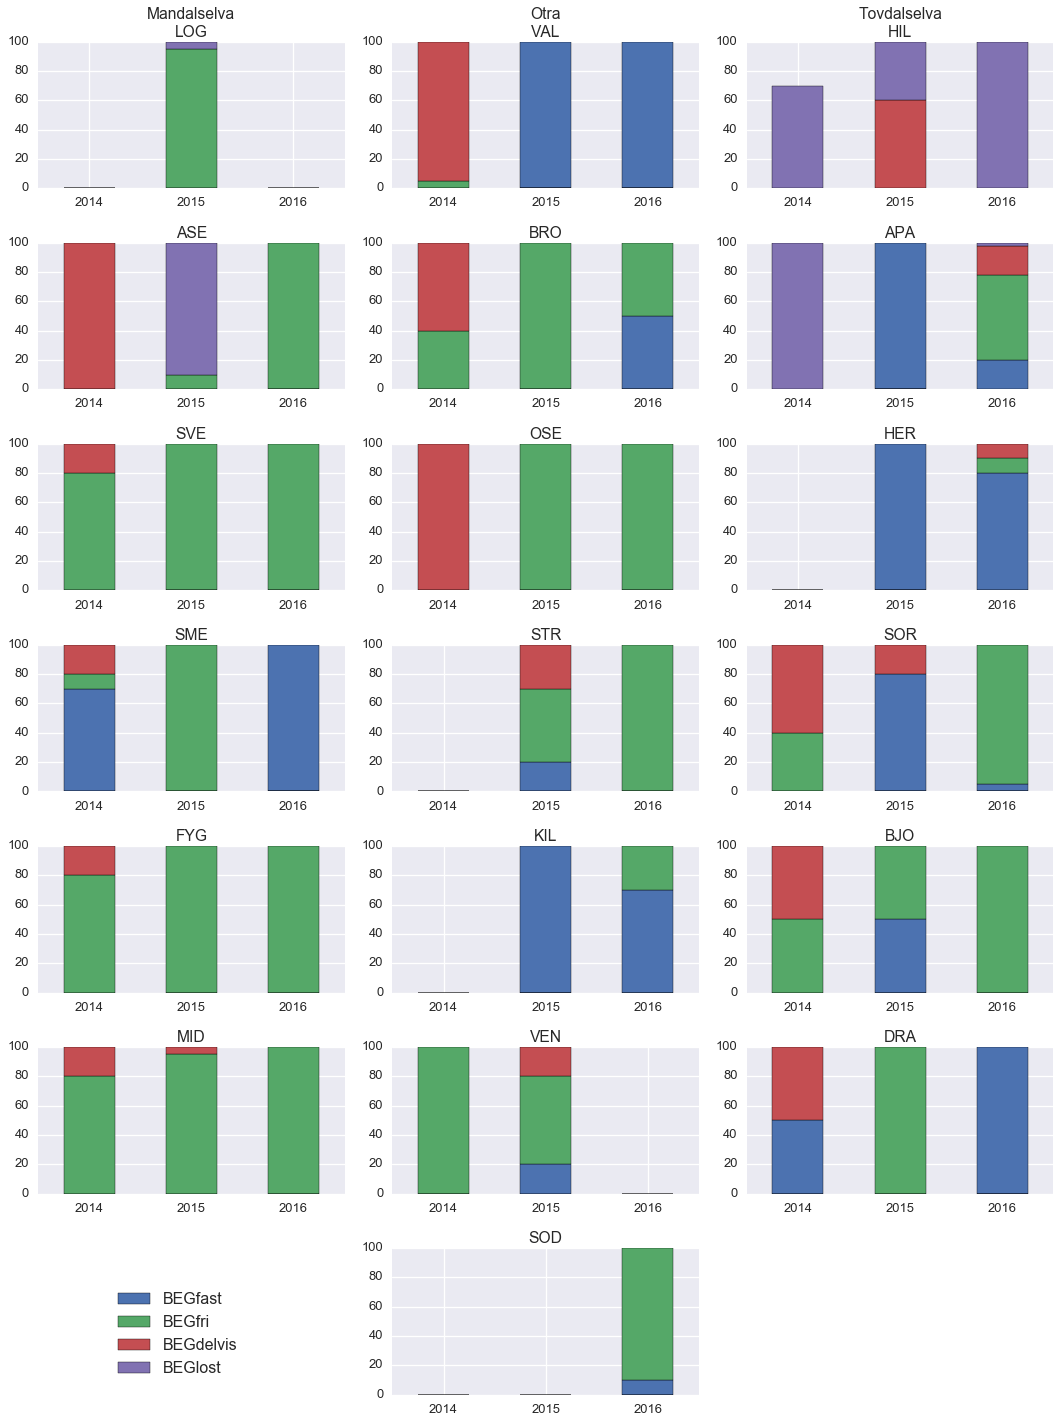

In [8]:
# Aggregate classes

# Get just the algal data again
alg_df2 = df[list(set(df.columns) - sub_cols)]
del alg_df2['BEGsum']

# Empty df with ordered index. Used to fill missing
# years at some sites with NaN
idx_df = pd.DataFrame({}, index=[2014, 2015, 2016])

# Plot
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(15,20))

# Rivers by column
for col, riv in enumerate(['Mandalselva', 'Otra', 'Tovdalselva']):
    riv_df = alg_df2.query('River == @riv')

    # Sites by row
    for row, site in enumerate(riv_df['Name'].unique()):
        site_df = riv_df.query('Name == @site')
        site_df.drop(['River', 'Kortnavn', 'ID', 'Name'], axis=1, inplace=True)
        site_df.set_index('Year', inplace=True)
        site_df = idx_df.join(site_df)
        site_df.plot.bar(stacked=True, ax=axes[row, col], legend=False)

        # Titles etc.
        if row == 0:
            axes[row, col].set_title('%s\n%s' % (riv, site))
        else:
            axes[row, col].set_title(site)
        axes[row, col].set_xlabel('')
        axes[row, col].set_xticklabels(axes[row, col].xaxis.get_majorticklabels(), 
                                       rotation=0)
        
        # Legend
        if (row==6) and (col==1):
            axes[row, col].legend(loc='upper center', bbox_to_anchor=(-0.7, 0.8), 
                                  fontsize=16)

# We only have 6 sites at Mandalselva and Tovdalselva, so
# remove 7th row for these
fig.delaxes(axes[6, 0])
fig.delaxes(axes[6, 2])

plt.tight_layout()

### 1.3. Nuisance versus Non-nuisance sites

I've added a sheet called `site_type` to `proportions.xslx`, highlighting whether Krypsiv is a problem (`type = PV`) or not (`type = Ref`) at each location. The aim here is to visualise whether the class distributions are different between nuisance and non-nuisance sites.  

In [9]:
# Read site_type
typ_df = pd.read_excel(in_xls, sheetname='site_type')
del typ_df['Kortnavn']

# Join
alg_df = pd.merge(alg_df, typ_df,
                  how='left', on='Name')

alg_df.head()

,Kortnavn,Name,ID,River,Year,Class,Proportion (%),Type
0,LOG,LOG,1,Mandalselva,2014,BEGfast,NaN,Ref
1,LOG,LOG,1,Mandalselva,2015,BEGfast,0.0,Ref
2,LOG,LOG,1,Mandalselva,2016,BEGfast,NaN,Ref
3,ÅSE,ASE,2,Mandalselva,2014,BEGfast,0.0,PV
4,ÅSE,ASE,2,Mandalselva,2015,BEGfast,0.0,PV


As a start, let's plot the **mean** proportion for each class (over all sites on all rivers), split according to whether each site is a nuisance location or not. Black lines indicate **95% confidence intervals** on the means estimated using bootstrapping.

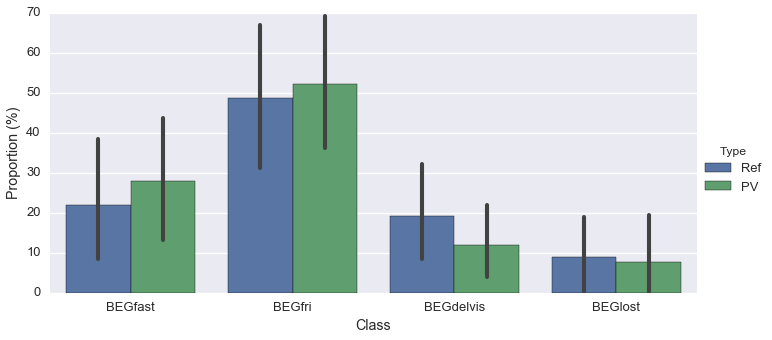

In [10]:
sn.factorplot(x='Class', y='Proportion (%)', hue='Type',
              data=alg_df, 
              kind='bar', 
              size=5, aspect=2, 
              estimator=np.mean, ci=95)

It's clear there are no significant differences here. For an alternative view of the same data, we can also plot the bar heights as **medians**, rather than means.

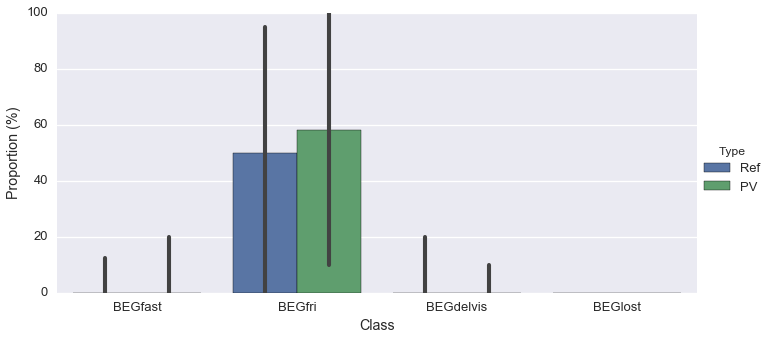

In [11]:
sn.factorplot(x='Class', y='Proportion (%)', hue='Type',
              data=alg_df, 
              kind='bar', 
              size=5, aspect=2, 
              estimator=np.median, ci=95)

The differences here are even less obvious, and the conclusions are the same - there are no significant differences in algal composition. Overall, the bar chart using means is probably a bit nicer to look at.

Finally, instead of bar charts we could create **box plots**. This would usually be my preferred option for this kind of data, but the dispersion is so large in this dataset that I suspect the bar plots will look nicer.

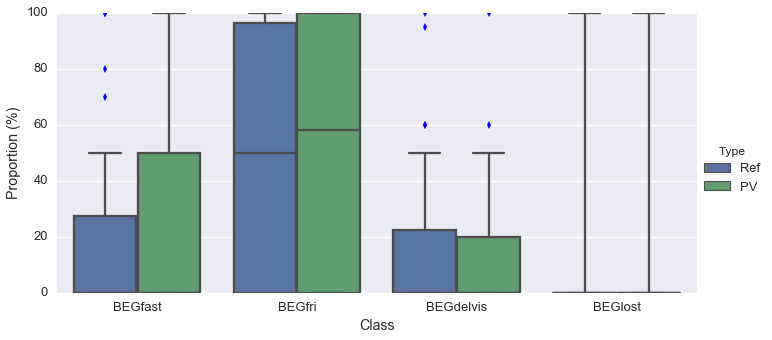

In [12]:
sn.factorplot(x='Class', y='Proportion (%)', hue='Type',
              data=alg_df, 
              kind='box', 
              size=5, aspect=2)

Overall, I think I probably prefer the versions where the bars represent mean, although any of the above would be fine. We can also try a version split by river.

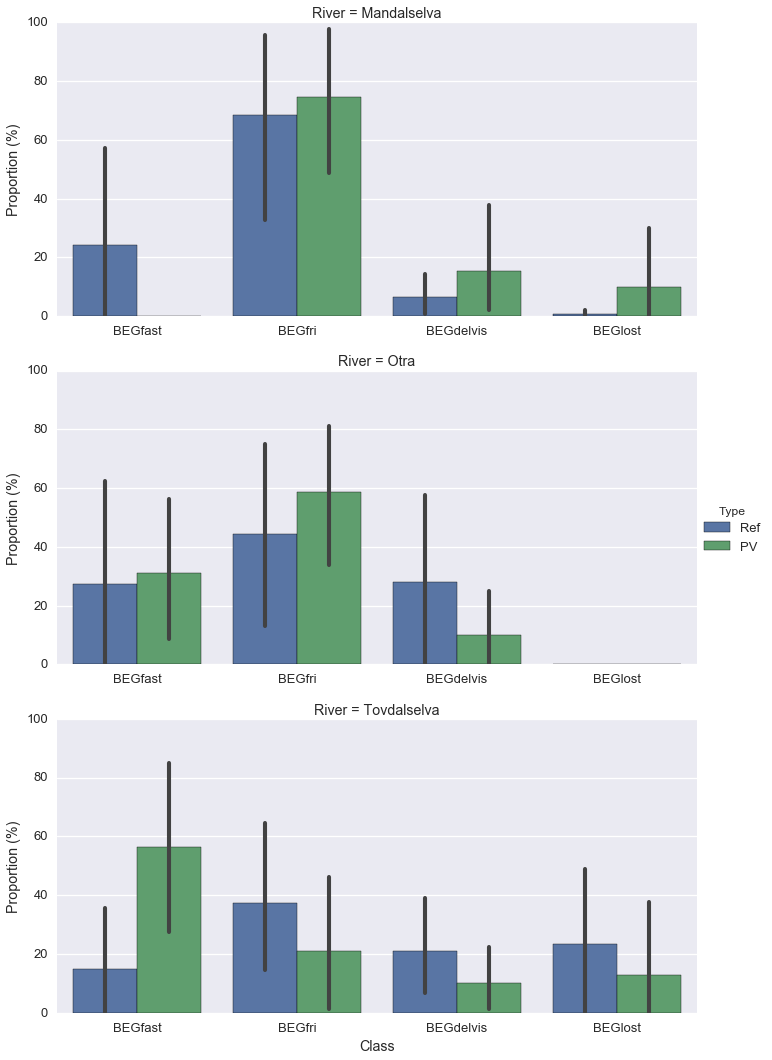

In [13]:
sn.factorplot(x='Class', y='Proportion (%)', hue='Type',
              data=alg_df, row='River',
              kind='bar', sharex=False,
              size=5, aspect=2, 
              estimator=np.mean, ci=95)

## 2. Water chemistry

I've extracted the water chemistry data into a new Excel file called `chem.xlsx`. Note that I'm not exactly sure which variables Therese would like plotting. For example, there are several different versions of pH. Also, some of the column headings in 2014 are slightly different to those in later years. **Check with Therese to make sure I'm using the right data columns**. Finally, most of the chemistry data for 2016 seems to be missing, so **check this too**.

**The data in `chem.xlsx` need updating and correcting**, but it should allow me to get the code set up for use later.

In [14]:
# Read data
in_xls = (r'C:\Data\James_Work\Staff\Therese_FM\Bulbous_Rushes\Data'
          r'\Tidied\chem.xlsx')
df = pd.read_excel(in_xls, sheetname='data')

# 'Melt' to long data format
df = pd.melt(df, 
             id_vars=['Kortnavn', 'Name', 'ID', 'Year'], 
             var_name='Param', 
             value_name='Value')

# Join in PV or Ref
df = pd.merge(df, typ_df,
              how='left', on='Name')

df.head()

,Kortnavn,Name,ID,Year,Param,Value,Type
0,LOG,LOG,1,2014,PW_cond_AVE,NaN,Ref
1,LOG,LOG,1,2015,PW_cond_AVE,60.000000,Ref
2,LOG,LOG,1,2016,PW_cond_AVE,26.833333,Ref
3,ÅSE,ASE,2,2014,PW_cond_AVE,61.166667,PV
4,ÅSE,ASE,2,2015,PW_cond_AVE,59.333333,PV


### 2.1. Line plots per site

For each site, we can create a simple line plot for each chemical parameter in each year. The example below shows the results for site `ASE`, but it would be easy to generate plots like this for all the other sites if desired.

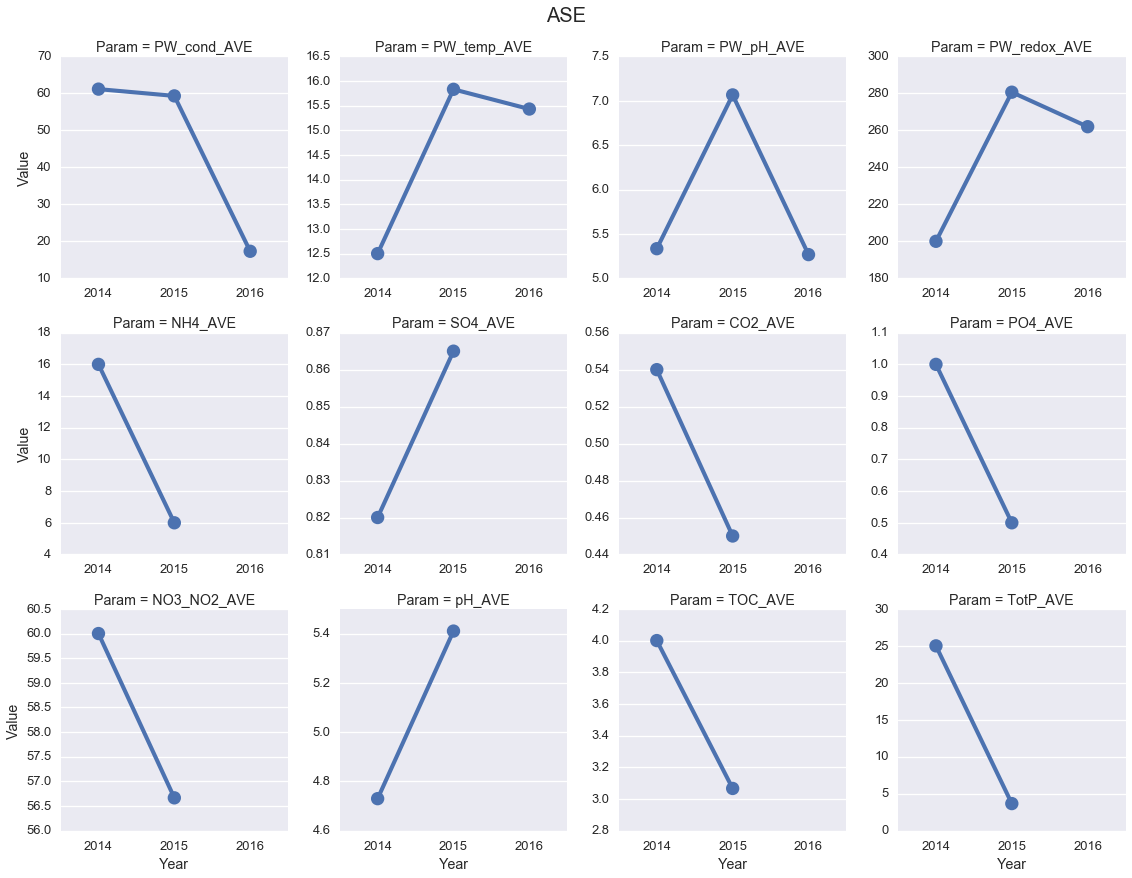

In [15]:
site_df = df.query('Name == "ASE"')

# Plot
sn.factorplot(x='Year', y='Value', 
              col='Param', col_wrap=4,
              data=site_df, 
              kind='point',
              sharex=False,
              sharey=False)

plt.suptitle('ASE', fontsize=20, y=1.02)

### 2.2. Line plots for all sites

It's also possible to create plots for all the sites in a single figure, but it's not very eyesight-friendly!

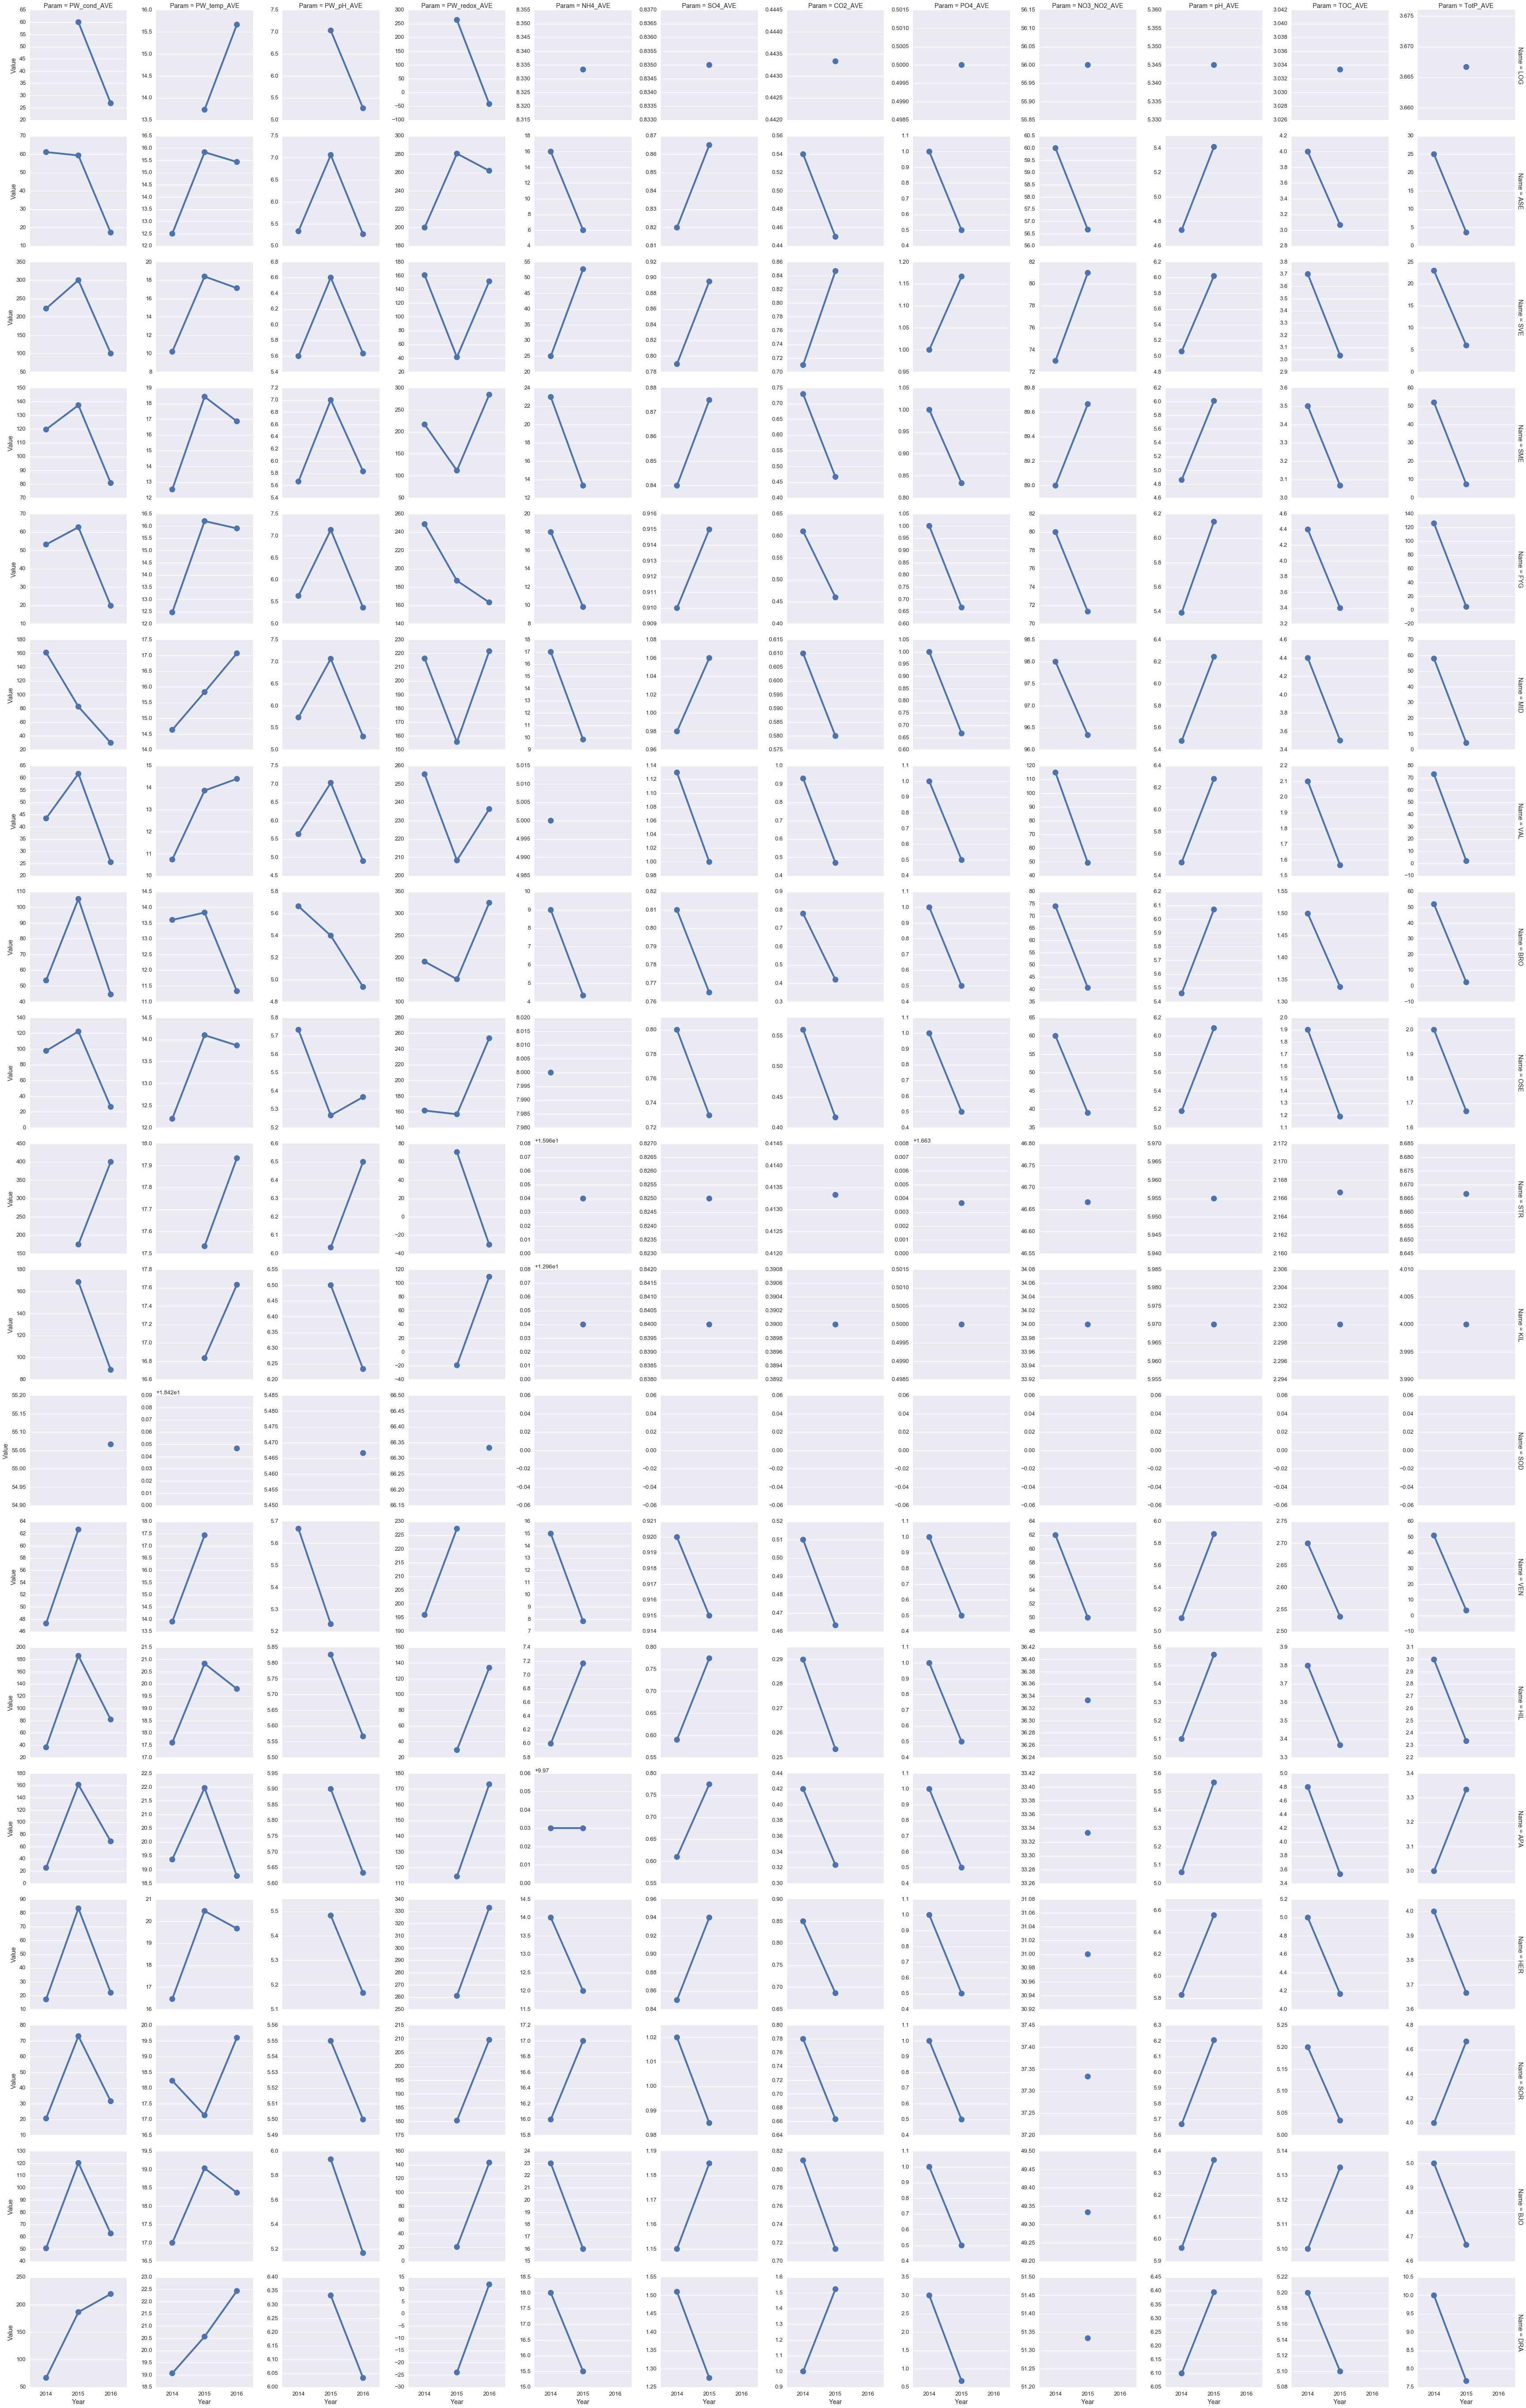

In [16]:
# Plot
sn.factorplot(x='Year', y='Value', 
              col='Param', row='Name',
              data=df, 
              kind='point',
              #sharex=False,
              sharey=False,
              margin_titles=True)

### 2.3. Nuisance versus non-nuisance for each parameter

Therese's e-mail also mentions looking at the differences between nuisance and non-nuisance sites for each parameter.

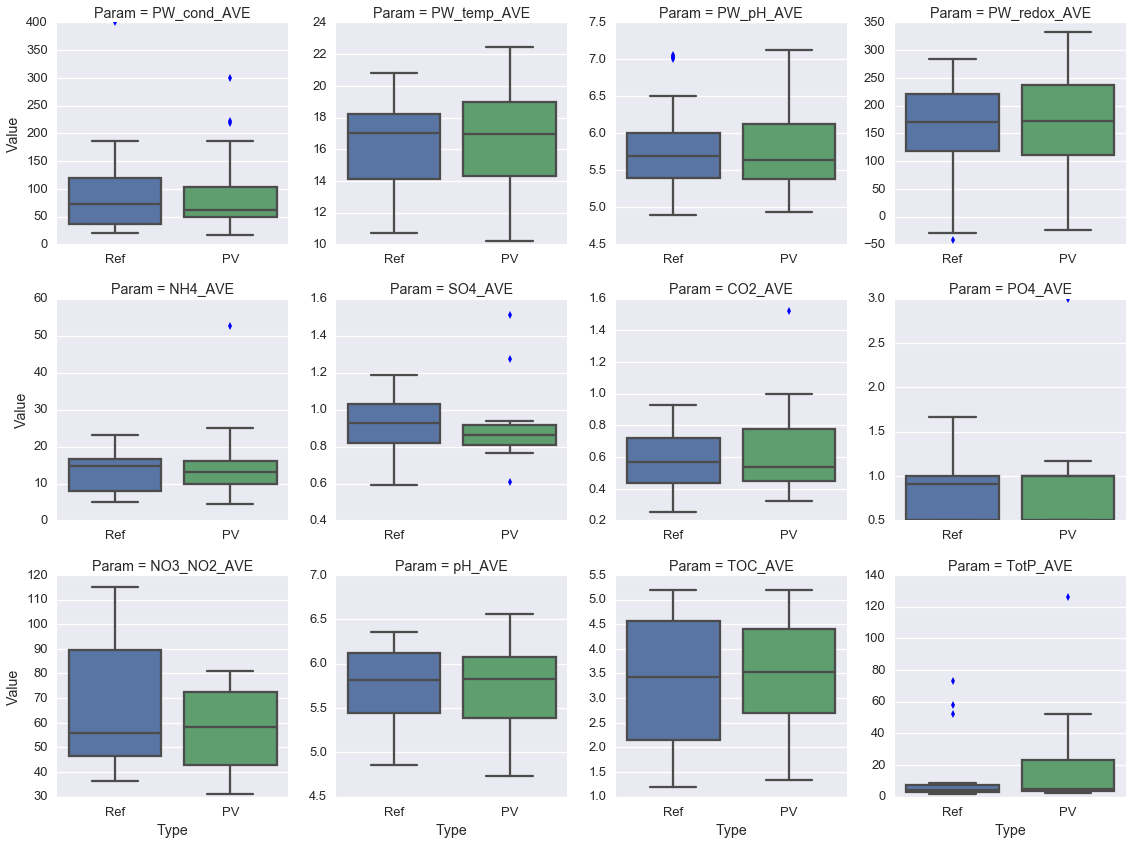

In [17]:
# Plot
sn.factorplot(x='Type', y='Value',
              col='Param', col_wrap=4,
              data=df, 
              kind='box',
              sharex=False,
              sharey=False)

### 2.4. Nuisance versus non-nuisance for each parameter, split by year 

We can also further split this dataset by year.

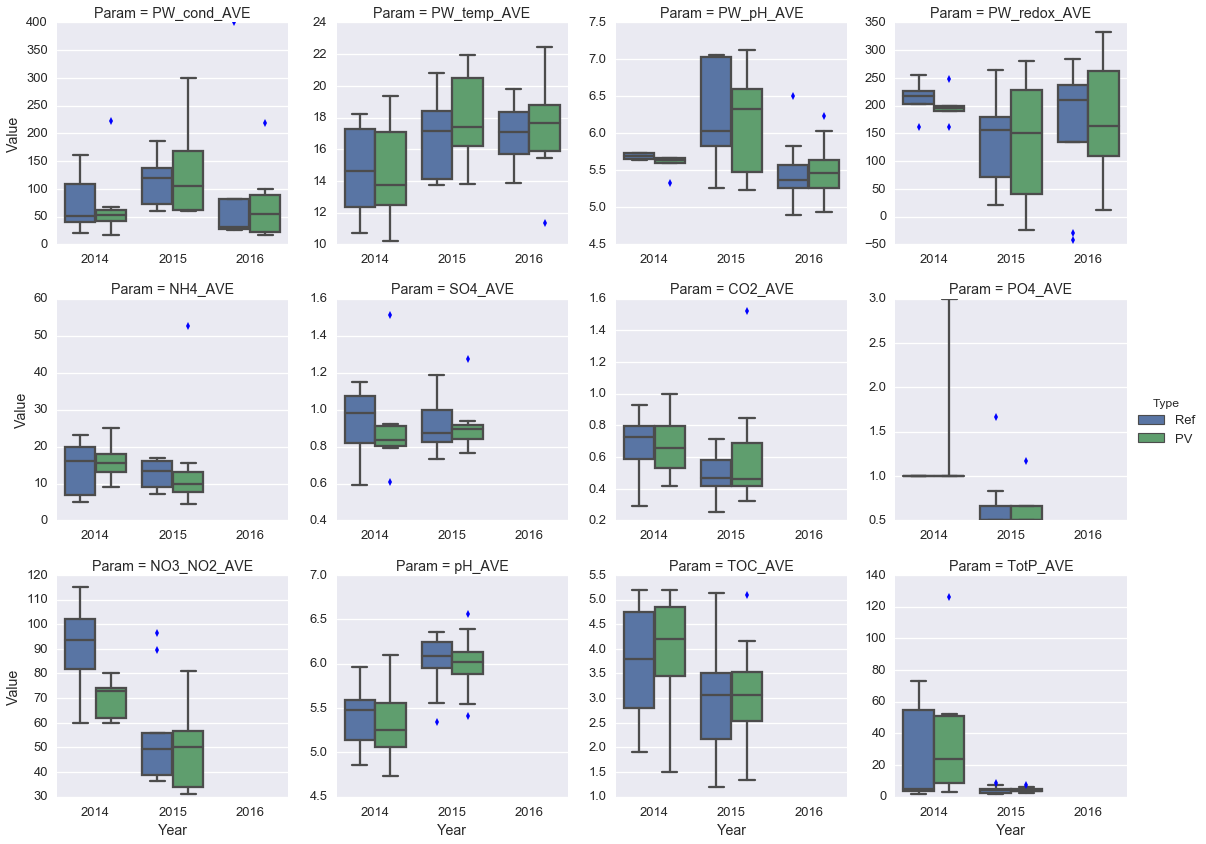

In [18]:
# Plot
sn.factorplot(x='Year', y='Value', hue='Type',
              col='Param', col_wrap=4,
              data=df, 
              kind='box',
              sharex=False,
              sharey=False)